# Super resolution of depth image using RGB image

Based on http://ieeexplore.ieee.org.sci-hub.io/document/7362701/

This is conceptually simple. Given a picture and its approximate / low quality depth map, use the greyscale version of the RGB image to make the depth map sharper and with more details.

We'll see all of that in that notebook.

There are some related articles from the same guys, [IMAGE COLORIZATION ALGORITHM USING SERIES APPROXIMATED SPARSE
FUNCTION](http://ieeexplore.ieee.org.sci-hub.io/document/6853790/) probably being the most useful since it's really similar to that one.

First, let's do some imports.

In [2]:
#imports
%load_ext autoreload
%autoreload 2

import cv2
import sys
import numpy as np
import numpy.random
import scipy.sparse as sp
import scipy.sparse.linalg
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

def showarray(a, fmt='png'):
    a = np.uint8((a - a.min()) / (a.max() - a.min()) * 255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
numpy.set_printoptions(linewidth=1000000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's define some parameters: the size of image we want to work with, and a scaling factor for display

In [3]:
#params
sz = 500
zoom = 5

Load the images. Resize them. Convert them to greyscale. Convert them to float.

From now on, we can work with `img` and `depth`, which have values from 0 to 255

BITE MOLLE
[[ 156.  157.  157. ...,   84.   85.   86.]
 [ 157.  156.  157. ...,   83.   85.   84.]
 [ 157.  156.  157. ...,   82.   85.   82.]
 ..., 
 [  74.   72.   72. ...,   57.   60.   63.]
 [  74.   73.   72. ...,   56.   60.   61.]
 [  74.   72.   73. ...,   54.   58.   60.]]
(500, 500)
[-1.  0.  0. ...,  2.  2.  1.]


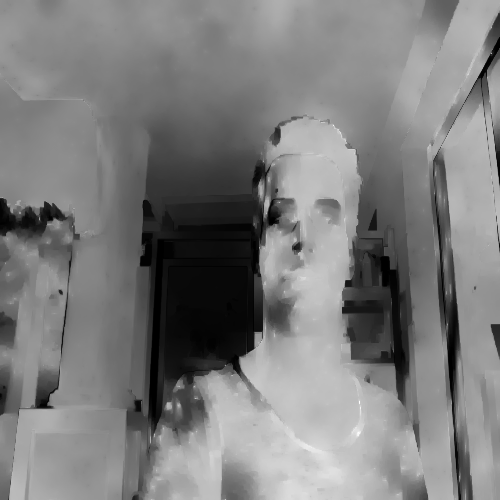

error: /build/opencv-SviWsf/opencv-2.4.9.1+dfsg/modules/imgproc/src/color.cpp:3642: error: (-215) depth == CV_8U || depth == CV_16U || depth == CV_32F in function cvtColor


In [13]:
%reload_ext autoreload
%autoreload 2
import depth_sharpener

# load images
img = cv2.imread("./img.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (sz, sz))
#img = img.astype(float)

depth = cv2.imread("./depth.png")
depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
depth = cv2.resize(depth, (sz, sz)).astype(float)
#depth = depth.astype(float)

showarray(depth_sharpener.sharpen_depth(img, depth))

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
depth = cv2.resize(depth, (sz, sz)).astype(float)

M, N = img.shape

print("img")
print(img)
showarray(img)

print("depth")
print(depth)
showarray(depth)



Make the D matrix.

D is the vertical AND horizontal difference operator.

`D.dot(img)` outputs the horizontal flattened image in `[:M * N - M]` and the vertical difference image in `[M * N - M:]`

In [4]:
def make_D(N, M):
    u = sp.diags([[1] * (M - 1), [-1] * (M - 1)], [0, 1], shape=(M - 1, M))
    U = sp.block_diag([u] * N)

    V = sp.diags(
        [[1] * (M * (N - 1)), [-1] * (M * (N - 1))], [0, M],
        shape=(M * (N - 1), M * N))
    return sp.hstack([U.T, V.T]).T


D = make_D(M, N)
print('D done', D.shape, D.size)

('D done', (499000, 250000), 998000)


Create `d_img` vector, the vertical and horizontal gradient of `img`. Create `dx` and `dy`, the reshaped and rescaled difference images, used only for display.

('d_img done', (499000,), 499000)
[-1.  0.  0. ...,  1.  2.  1.]
dx
[[ -1.   0.   0. ...,   0.  -1.  -1.]
 [  1.  -1.   0. ...,  -1.  -2.   1.]
 [  1.  -1.   0. ...,   0.  -2.   2.]
 ..., 
 [  2.   0.   1. ..., -10.  -4.  -2.]
 [  1.   1.   0. ..., -10.  -4.  -1.]
 [  1.   0.   0. ..., -10.  -3.  -2.]]


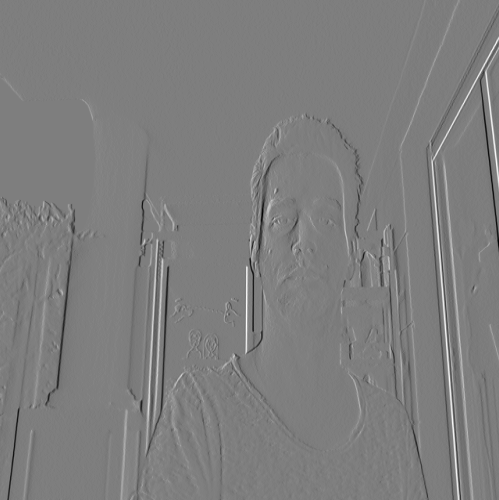

dy
[[-1.  1.  0. ...,  1.  0.  2.]
 [ 0.  0.  0. ...,  1.  1.  2.]
 [-1. -1.  0. ..., -1.  0.  3.]
 ..., 
 [ 1.  1.  1. ..., -1.  0.  1.]
 [ 0. -1.  0. ...,  1.  1.  2.]
 [ 0.  0. -1. ...,  1.  2.  1.]]


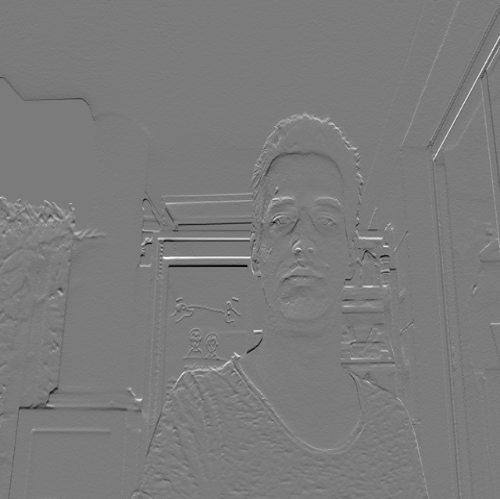

In [5]:
d_img = D.dot(img.flatten())
print('d_img done', d_img.shape, d_img.size)
print(d_img)

dx = d_img[:M * N - M].reshape(M, N - 1)

dy = d_img[M * N - M:].reshape(M - 1, N)

print("dx")
print(dx)
showarray(dx)
print("dy")
print(dy)
showarray(dy)

Create the `F` operator which is a pixel wise division comparison with the derivative of `img`.

Then, Create the `FD` operator which derives its input and compares is with the derivative of `img`

In [6]:
def abs_comp_matrix(img):
    return sp.diags([1.0/(np.abs(img.flatten()) + 1e-5)], [0])

def relu_comp_matrix(img, V):
    return sp.diags([1.0/(np.maximum(np.abs(img.flatten()), V) - V + 1e-5)], [0])

def soft_relu_comp_matrix(img, V):
    soft = np.log(1 + np.exp(np.abs(img.flatten()) - V))
    return sp.diags([1.0/(soft + 1e-5)], [0])
V = 2
F = soft_relu_comp_matrix(d_img, 0.001)
print('F done', F.shape, F.size)
#del d_img

FD = F.dot(D)
print('FD done', FD.shape, FD.size)
print(FD)

('F done', (499000, 499000), 499000)
('FD done', (499000, 250000), 998000)
  (0, 1)	-0.76188112051
  (0, 0)	0.76188112051
  (1, 2)	-1.44371537263
  (1, 1)	1.44371537263
  (2, 3)	-1.44371537263
  (2, 2)	1.44371537263
  (3, 4)	-0.76188112051
  (3, 3)	0.76188112051
  (4, 5)	-0.76188112051
  (4, 4)	0.76188112051
  (5, 6)	-0.76188112051
  (5, 5)	0.76188112051
  (6, 7)	-1.44371537263
  (6, 6)	1.44371537263
  (7, 8)	-0.328122227363
  (7, 7)	0.328122227363
  (8, 9)	-0.76188112051
  (8, 8)	0.76188112051
  (9, 10)	-1.44371537263
  (9, 9)	1.44371537263
  (10, 11)	-1.44371537263
  (10, 10)	1.44371537263
  (11, 12)	-1.44371537263
  (11, 11)	1.44371537263
  (12, 13)	-0.76188112051
  :	:
  (498987, 249487)	0.470354216591
  (498988, 249988)	-0.76188112051
  (498988, 249488)	0.76188112051
  (498989, 249989)	-1.44371537263
  (498989, 249489)	1.44371537263
  (498990, 249990)	-0.76188112051
  (498990, 249490)	0.76188112051
  (498991, 249991)	-0.76188112051
  (498991, 249491)	0.76188112051
  (498992, 24999

# Doing the actual thing

This is where it starts to get messy.

First, I create a `C` matrix (like "constraints") which does a random sampling of pixels in the image. It's an identity matrix with most 1s on the diagonal changed to 0.

`lam` is a hyper parameters meant to choose whether we favor flattening the gradient of the generated image or staying as close as possible to the sampled pixel values.

The objective function is

$$ \underset{x}{\text{argmin}} \lVert{FDx}\rVert_2^2 + \lambda \lVert C(x - d) \rVert_2^2$$

If we want to make it really look like a least square minimization, we can rewrite it like this

$$ \underset{x}{\text{argmin}} \lVert FDx - 0 \rVert_2^2 + \lVert \lambda Cx - \lambda Cd \rVert_2^2 $$

And if we want only one squared term,

$$
\underset{x}{\text{argmin}}
\left \lVert
  \left(\begin{array}{c} FD \\ \lambda C \end{array}\right)
  x -
  \left(\begin{array}{c} 0 \\ \lambda Cd \end{array}\right)
\right \rVert_2^2
$$

Now, that looks like a $ \lVert Ax - b \rVert_2^2$ least square problem that can be solved with [scipy's LSQR](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html ) . This can be interpreted as

> We want $x$ transformed by $A$ to look like $b$.

In this case, it means

> We want the division of the depth gradient and the greyscale image gradient to be zero (which I don't understand, should be like a smoothing constraint and a similarity constraint), and the sampled pixels to remain unchanged in the result.

However, it doesn't work.

Why are they trying to make `Ddepth/Dimg` close to 0? What's the meaning of that? How to properly handle the zeros in `Dimg`?

('A', (749000, 250000))
('b', (749000,))
('d', (250000,))
[ 0.0811749   0.01710052  0.03612517 ...,  0.08541411  0.10149672  0.07583992]
Difference


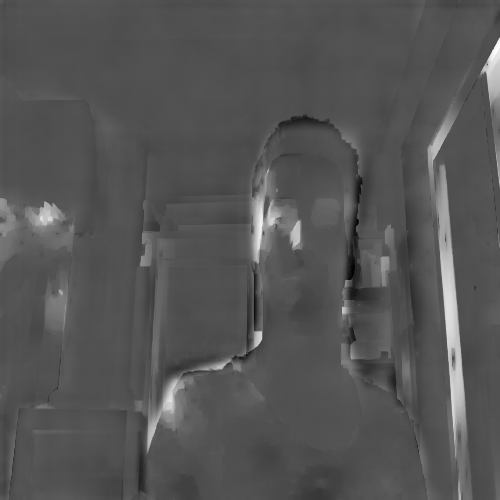

recovered depth
[ 178.95467849  178.87350359  178.85640307 ...,  182.67816594  182.05339054  181.95076957]


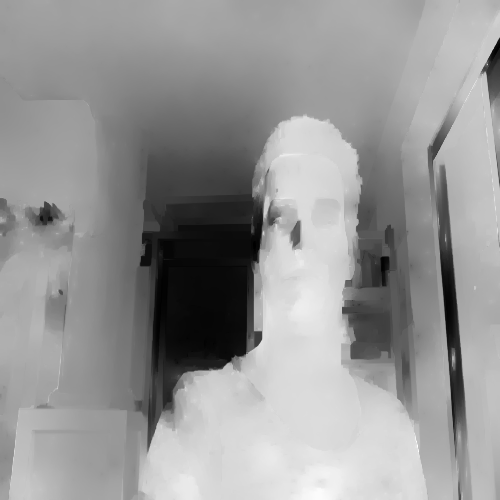

original depth


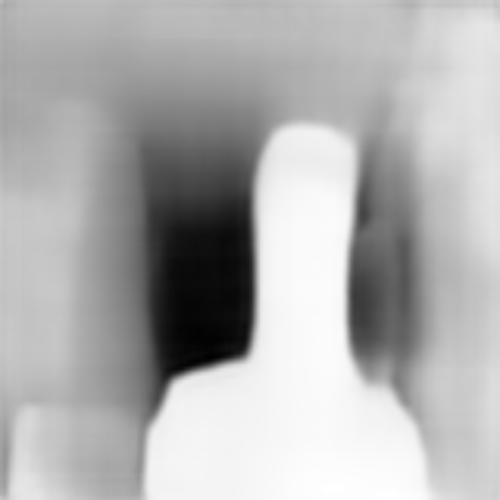

In [7]:
lam = 1e4

C = sp.diags([0 + (np.random.rand(M * N) < 0.005)], [0])

A = sp.vstack([FD, lam * C])
b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
d = sp.linalg.lsqr(A, b, iter_lim=500)


print('A', A.shape)
print('b', b.shape)
print('d', d[0].shape)

d = d[0]

print(D.dot(d))

print("Difference")
showarray((depth - d.reshape(M, N)))

print("recovered depth")
print(d)
showarray(d.reshape(M, N))
print("original depth")
showarray(depth)

# Now we can iterate

We can iterate by mutually improving the depth and the greyscale image.

1. We initially improve the depth image
2. Then, we re-optimize the greyscale image to make its derative look a bit more like the depth's image
3. We re-optimize a depth image from that greyscale image
4. Do 2) and 3) a few times.

recovered depth


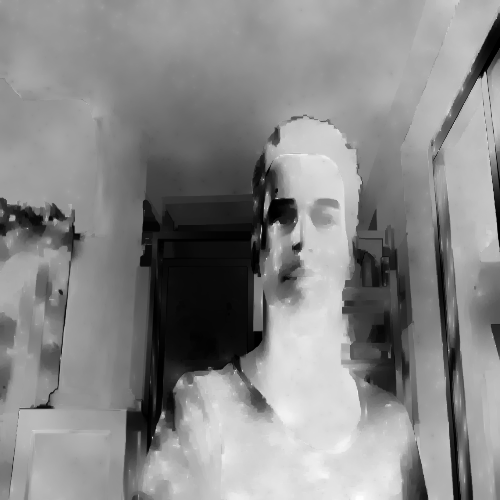

iteration 0
recovered greyscale


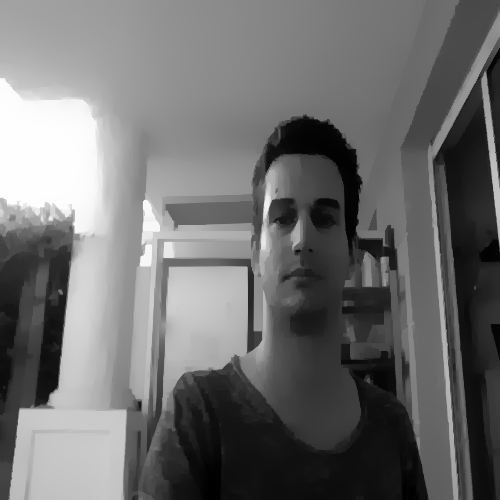

recovered depth


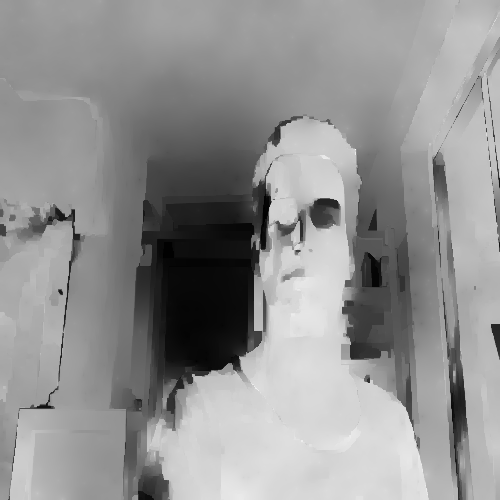

iteration 1
recovered greyscale


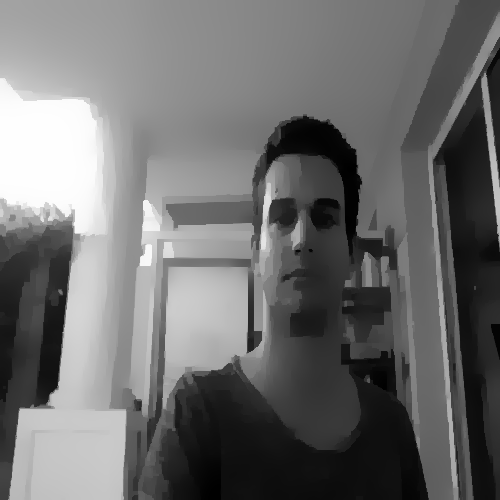

recovered depth


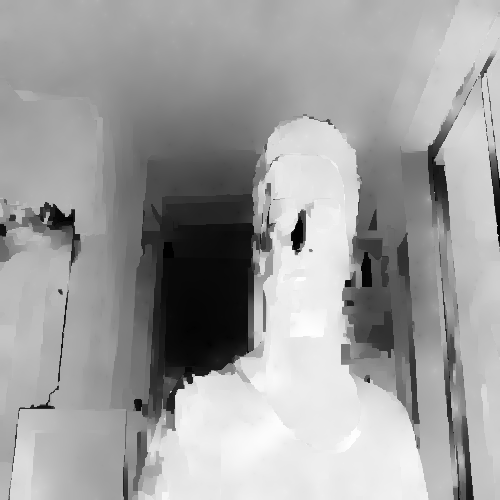

iteration 2
recovered greyscale


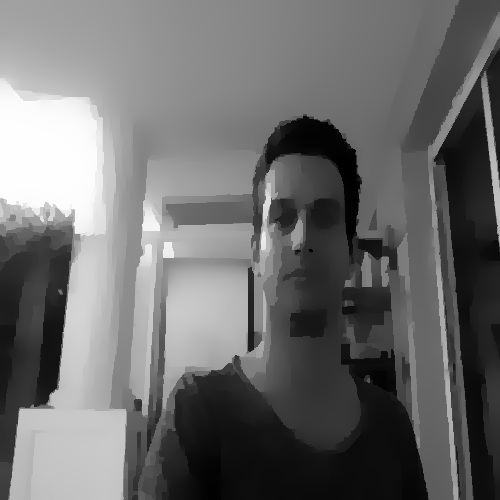

recovered depth


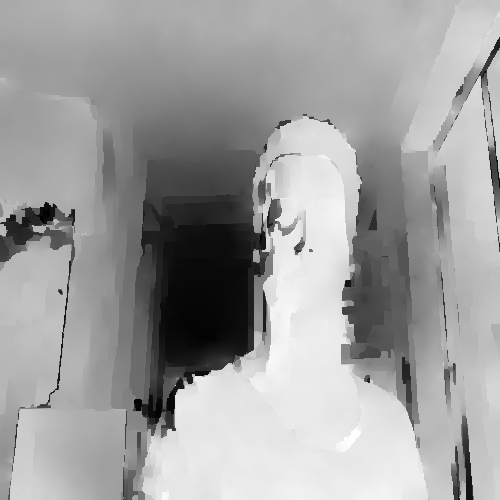

In [8]:
lam = 1e4
lam2 = 1e-1
V = 0.001
nb_iter = 300
comp = soft_relu_comp_matrix

C = sp.diags([0 + (np.random.rand(M * N) < 0.005)], [0])

F = comp(d_img, V)
A = sp.vstack([F.dot(D), lam * C])
b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
d = sp.linalg.lsqr(A, b, iter_lim=nb_iter)[0]

print("recovered depth")
showarray(d.reshape(M, N))

for i in range(3):
    print("iteration " + str(i))
    d2 = D.dot(d)

    G = comp(d2, V)

    A = sp.vstack([G.dot(D), lam2 * sp.identity(img.size)])
    b = np.hstack([np.zeros((2 * M * N - M - N, )), lam2 * img.flatten()])
    i = sp.linalg.lsqr(A, b, iter_lim=nb_iter)[0]
    
    print("recovered greyscale")
    showarray(i.reshape(M, N))
    C = sp.diags([0 + (np.random.rand(M * N) < 0.005)], [0])
    F2 = np.abs(D.dot(i))
    F2 = comp(F2, V)
    A = sp.vstack([F2.dot(D), lam * C])
    b = np.hstack([np.zeros((2 * M * N - M - N, )), (lam * C).dot(depth.flatten())])
    d = sp.linalg.lsqr(A, b, iter_lim=nb_iter)[0]

    print("recovered depth")
    showarray(d.reshape(M, N))